In [31]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [32]:
from scipy.sparse import linalg as slin
from tqdm import tqdm

class Sketch:
    def __init__(self):
        self.Omega = None
        self.Psi = None
        self.Y = None
        self.W = None
        self.shape = None
        self.r = 0
    
    def init(self, r):
        self.r = r
        
        m, n = X0.shape
        self.shape = X0.shape
        
        k = 2 * r + 1
        l = 4 * r + 3
        
        self.Omega = np.random.randn(n, k)
        self.Psi = np.random.randn(l, m)
        
        # Sketch consists of two matrices Y and W
        # that capture the range and co-range of X
        self.Y = np.zeros((m, k))
        self.W = np.zeros((l, n))
        
    def CGMU_update(self, u, v, nu):
        '''
        Rank-1 update of sketch 
        '''
        self.Y = (1 - nu) * self.Y + nu * u @ (v.conj().T @ self.Omega)
        self.W = (1 - nu) * self.W + nu * (self.Psi @ u) @ v.conj().T
        
    def reconstruct(self):
        '''
        Reconstructs matrix from sketch
        '''
        Q, _ = np.linalg.qr(self.Y) # Q = orth(Y)
        B = np.linalg.pinv(self.Psi @ Q) @ self.W
        
        U, S, V = np.linalg.svd(B, full_matrices=False)
                
        return Q @ U[:, :self.r] @ np.diag(S[:self.r]) @ V[:self.r, :]
    
    def factorize(self, num_iter=50, alpha = 1.0, eps=1e-10):
        '''
        Solves optimization problems and stores the result in sketch
        '''
        z = np.ones(self.shape).reshape(-1)
        
        # Perform conditional gradient process
        for i in tqdm(range(num_iter)):
            u, _, v = np.linalg.svd(A_star(grad_f(z))) #(u, v) = MaxSingVec(A* (grad f(z)))
            u = u[:, :1]
            v = v[:1, :].conj().T
            
            h = A((-alpha * u @ v.T)) # A(X) is the set of linear measurements of the matrix X
            e = (z - h) @ grad_f(z)
            
            err.append(np.abs(e))
            if np.abs(e) <= eps :
                break
            
            nu = 2 / (i + 2)
            z = (1 - nu) * z + nu * h
            self.CGMU_update(-alpha * u, v, nu)

Let's load vectorized video frames into matrix.

In [24]:
import os

root_dir = "./Bootstrap/"

paths = sorted(os.listdir(root_dir))
paths_nr = len(paths)

F = np.empty((19200, paths_nr))

for j, path in tqdm(enumerate(paths)):
    img = Image.open(root_dir + path).convert('L')
    F[:, j] = np.array(img).astype(np.float64).flatten()

3055it [00:01, 2666.70it/s]


In [25]:
_, D, _, = np.linalg.svd(F)

In [26]:
print("F is {0} x {1} matrix, rank is {2}".format(F.shape[0], F.shape[1], len(D.nonzero()[0])))

F is 19200 x 3055 matrix, rank is 3055


One can see that F has full column rank. Let's check that matrix F is convenient for background/foreground sepration by figuring out it's singular values.

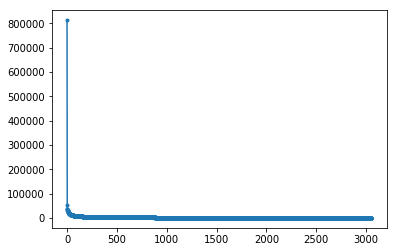

In [27]:
plt.plot(D, '.-')

In [367]:
X0 = F
alpha = np.trace(X0)

def f(x, b):
    return np.norm(x - b) ** 2

def grad_f(x):
    b = X0.reshape(-1)
    return 2 * (x - b)

def A(X):
    return X.reshape(-1)

def A_star(x):
    return x.reshape(X0.shape)

err = []
sketch = Sketch()
sketch.init(400)
sketch.factorize(alpha=alpha, num_iter=10)
X_rec = sketch.reconstruct()


100%|██████████| 10/10 [30:09<00:00, 189.59s/it]


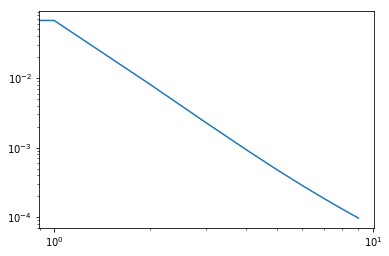

In [503]:
err2 = np.array(err) / np.linalg.norm(F)
plt.loglog(err2)

Processed 20-th frame of video:

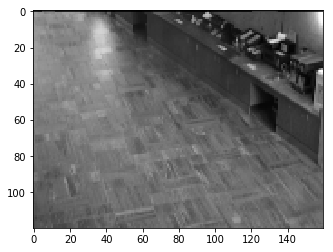

In [427]:
F_rec = X_rec

def get_image(M, j):
    img = M[:, j].reshape(120, 160)
    img = img / img.max() * 255
    img = img.astype(np.uint8)
    
    return img

plt.imshow(get_image(F_rec, 19), cmap='gray')

Original 20-th frame of video:

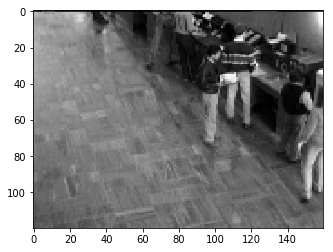

In [428]:
plt.imshow(get_image(F, 19), cmap='gray')

Let's check that low-rank part is actually low-rank, in other words, let's check that background remains almost the same. Futher it can be seen in backgound video.

In [429]:
print("Rank of low-rank part is", np.linalg.matrix_rank(F_rec))

Rank of low-rank part is 3


Now we can compile videos from frames of separated background and foregound

In [495]:
import os

back_dir = "./background/"
fore_dir = "./foreground/"
orig_dir = "./original/"

def save_bmps(orig_dst, back_dst, fore_dst, M, M_rec):
    assert M.shape == M_rec.shape

    for j in range(M_rec.shape[1]):
        back_j = M_rec[:, j].reshape(120, 160)
        back_j = back_j * 255 / back_j.max()
        
        orig_j = M[:, j].reshape(120, 160)
        
        fore_j = np.maximum(0, orig_j - back_j)

        back_j = Image.fromarray(back_j.astype(np.uint8))
        back_j.save(back_dst + 'b{0:05d}.bmp'.format(j))

        fore_j = Image.fromarray(fore_j.astype(np.uint8))
        fore_j.save(fore_dst + 'b{0:05d}.bmp'.format(j))

        orig_j = Image.fromarray(orig_j.astype(np.uint8))
        orig_j.save(orig_dst + 'b{0:05d}.bmp'.format(j))

In [496]:
os.makedirs(back_dir, exist_ok=True)
os.makedirs(fore_dir, exist_ok=True)
os.makedirs(orig_dir, exist_ok=True)
save_bmps(orig_dir, back_dir, fore_dir, F, F_rec)

In [497]:
%%bash

function make_video {
    ffmpeg -framerate 60 -i $1/b0%04d.bmp -r 60 -y $1.mp4
}

for dir in Bootstrap original background foreground; do
    make_video $dir
done

ffmpeg version 4.0.3 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 8 (GCC)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --docdir=/usr/share/doc/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -g -pipe -Wall -Werror=format-security -Wp,-D_FORTIFY_SOURCE=2 -Wp,-D_GLIBCXX_ASSERTIONS -fexceptions -fstack-protector-strong -grecord-gcc-switches -specs=/usr/lib/rpm/redhat/redhat-hardened-cc1 -specs=/usr/lib/rpm/redhat/redhat-annobin-cc1 -m64 -mtune=generic -fasynchronous-unwind-tables -fstack-clash-protection -fcf-protection' --extra-ldflags='-Wl,-z,relro -Wl,-z,now -specs=/usr/lib/rpm/redhat/redhat-hardened-ld ' --extra-cflags=' ' --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libvo-amrwbenc --enable-version3 --enable-bzlib --disable-crystalhd --enable-fontconfig --enable-frei0r --enable-gcrypt --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-